Parul Pandey님의 https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert    
https://www.kaggle.com/raenish/tweet-sentiment-insight-eda 에서 영감을 받았습니다

In [1]:
# 파일시스템 관련
import os

# 데이터 처리 관련
import numpy as np
import pandas as pd

# 텍스트 전처리 관련
import re
import string
import nltk
from nltk.corpus import stopwords

# 데이터시각화 관련
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

#Transformers
# 4.4.0에서 버전문제 발생하여 3.3.1로 reinstall
from transformers import BertTokenizer
from transformers import *
import tokenizers
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## jaccard similarity 코드

In [3]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

### train을 train, test로 나눈다

In [4]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(train_ori,
#                                 test_size = 0.2,
#                                 random_state = 123)


In [5]:
# print(train.shape)
# print(test.shape)
# print(train.shape[0] + _test.shape[0])

In [6]:
# train.to_csv("./train_split_v1.csv")
# test.to_csv("./test_split_v1.csv")

# train_t = pd.read_csv("./train_split_v1.csv")
# train_t.head()

### hyuyoo code merge

In [7]:
train = pd.read_csv("./train_split.csv")
test = pd.read_csv("./test_split.csv")

In [8]:
test.head()

,textID,text,selected_text,sentiment
0,85a02242e3,"Its been a slow day at home, one of my kids is...","Its been a slow day at home, one of my kids is...",neutral
1,a0e0ed4311,about to head to Starbucks. was gonna take the...,missed,negative
2,f5f2a709ca,I like them. I mean I like what`s left of them.,I like them.,positive
3,064985c587,Grad present photos on facebook,Grad present photos on facebook,neutral
4,5ab37ce023,"That`s kinda cute, to be honest","kinda cute, to be honest",positive


In [9]:
print(train.sentiment.value_counts())
print()
print(train.sentiment.value_counts(normalize=True))

neutral     8919
positive    6838
negative    6227
Name: sentiment, dtype: int64

neutral     0.405704
positive    0.311044
negative    0.283251
Name: sentiment, dtype: float64


In [10]:
print(test.sentiment.value_counts())
print()
print(test.sentiment.value_counts(normalize=True))

neutral     2198
positive    1744
negative    1554
Name: sentiment, dtype: int64

neutral     0.399927
positive    0.317322
negative    0.282751
Name: sentiment, dtype: float64


-> train, test의 감정별 트윗 비율이 거의 유사하다

### test를 X, y로 분리

In [11]:
test_x = pd.DataFrame(test, columns=["textID","text","sentiment"])
test_x.head(3)

,textID,text,sentiment
0,85a02242e3,"Its been a slow day at home, one of my kids is...",neutral
1,a0e0ed4311,about to head to Starbucks. was gonna take the...,negative
2,f5f2a709ca,I like them. I mean I like what`s left of them.,positive


In [12]:
test_y = test.selected_text
test_y.head()

0    Its been a slow day at home, one of my kids is...
1                                               missed
2                                         I like them.
3                      Grad present photos on facebook
4                             kinda cute, to be honest
Name: selected_text, dtype: object

In [13]:
print(test_x.shape, test_y.shape)
print(test_x.columns, test_y.name)

(5496, 3) (5496,)
Index(['textID', 'text', 'sentiment'], dtype='object') selected_text


# 0.712 roBERTa model

In [14]:
# train, split -> merged from hyuyoo

In [15]:
def read_train():
    train=pd.read_csv('./train_split.csv')
    train['text']=train['text'].astype(str)
    train['selected_text']=train['selected_text'].astype(str)
    return train

def read_test():
    test=pd.read_csv('./test_split.csv')
    test['text']=test['text'].astype(str)
    return test

# def read_submission():
#     test=pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')
#     return test
    
train_df = read_train()
test_df_ori = read_test()
# submission_df = read_submission()

In [16]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [17]:
train_df.head(2)

,textID,text,selected_text,sentiment
0,b7797a8477,I created my account just to get a chance to ...,: I ADMIRE YOU! you`re amazing! you inspire me...,positive
1,cbdb23868f,too kind Jim too kind brother,kind,positive


In [18]:
print(train_df.shape, test_df_ori.shape)

(21984, 4) (5496, 4)


In [19]:
test_df_ori.head(2)

,textID,text,selected_text,sentiment
0,85a02242e3,"Its been a slow day at home, one of my kids is...","Its been a slow day at home, one of my kids is...",neutral
1,a0e0ed4311,about to head to Starbucks. was gonna take the...,missed,negative


In [20]:
test_df = pd.DataFrame(test_df_ori, columns=["textID","text","sentiment"])
answer_st = test_df_ori["selected_text"]

In [21]:
print(test_df.columns.values, ",", answer_st.name)

['textID' 'text' 'sentiment'] , selected_text


In [22]:
test_df.head(5)

,textID,text,sentiment
0,85a02242e3,"Its been a slow day at home, one of my kids is...",neutral
1,a0e0ed4311,about to head to Starbucks. was gonna take the...,negative
2,f5f2a709ca,I like them. I mean I like what`s left of them.,positive
3,064985c587,Grad present photos on facebook,neutral
4,5ab37ce023,"That`s kinda cute, to be honest",positive


In [23]:
answer_st[:5]

0    Its been a slow day at home, one of my kids is...
1                                               missed
2                                         I like them.
3                      Grad present photos on facebook
4                             kinda cute, to be honest
Name: selected_text, dtype: object

## Data Preprocessing

In [24]:
MAX_LEN = 96
PATH = './input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [25]:
ct = train_df.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train_df.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train_df.loc[k,'text'].split())
    text2 = " ".join(train_df.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train_df.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

In [26]:
ct = test_df.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test_df.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test_df.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test_df.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

## Model

In [27]:
def scheduler(epoch):
    return 3e-5 * 0.2**epoch

In [28]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(128, 2, padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model

## Train

In [29]:
# checkup
print(train_df.shape, test_df.shape)

(21984, 4) (5496, 3)


In [31]:
n_splits = 5

In [ ]:
"""
jac = []; VER='v4'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train_df.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    hist = model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=5, batch_size=8, verbose=DISPLAY, callbacks=[sv, reduce_lr],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train_df.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train_df.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train_df.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()
"""

In [33]:
tf.test.is_gpu_available()

True

In [34]:
## Inference

In [35]:
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))
DISPLAY=1
model = ""
for i in range(5):
    print('#'*25)
    print('### MODEL %i'%(i+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
    model.load_weights('./v4-roberta-%i.h5'%i)

    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/n_splits
    preds_end += preds[1]/n_splits

#########################
### MODEL 1
#########################


All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at ./input/tf-roberta/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Predicting Test...
172/172 [==============================] - 27s 157ms/step
#########################
### MODEL 2
#########################


All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at ./input/tf-roberta/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Predicting Test...
172/172 [==============================] - 26s 152ms/step
#########################
### MODEL 3
#########################


All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at ./input/tf-roberta/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Predicting Test...
172/172 [==============================] - 28s 160ms/step
#########################
### MODEL 4
#########################


All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at ./input/tf-roberta/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Predicting Test...
172/172 [==============================] - 29s 166ms/step
#########################
### MODEL 5
#########################


ResourceExhaustedError: OOM when allocating tensor with shape[768,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [ ]:
# import io
# stream = io.StringIO()
# model.summary(print_fn=lambda x: stream.write(x))
# summary_string = stream.getvalue()
# stream.close()
# summary_string

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 96, 768), (N 124645632   input_1[0][0]                    
______________________________________________________________________________________________

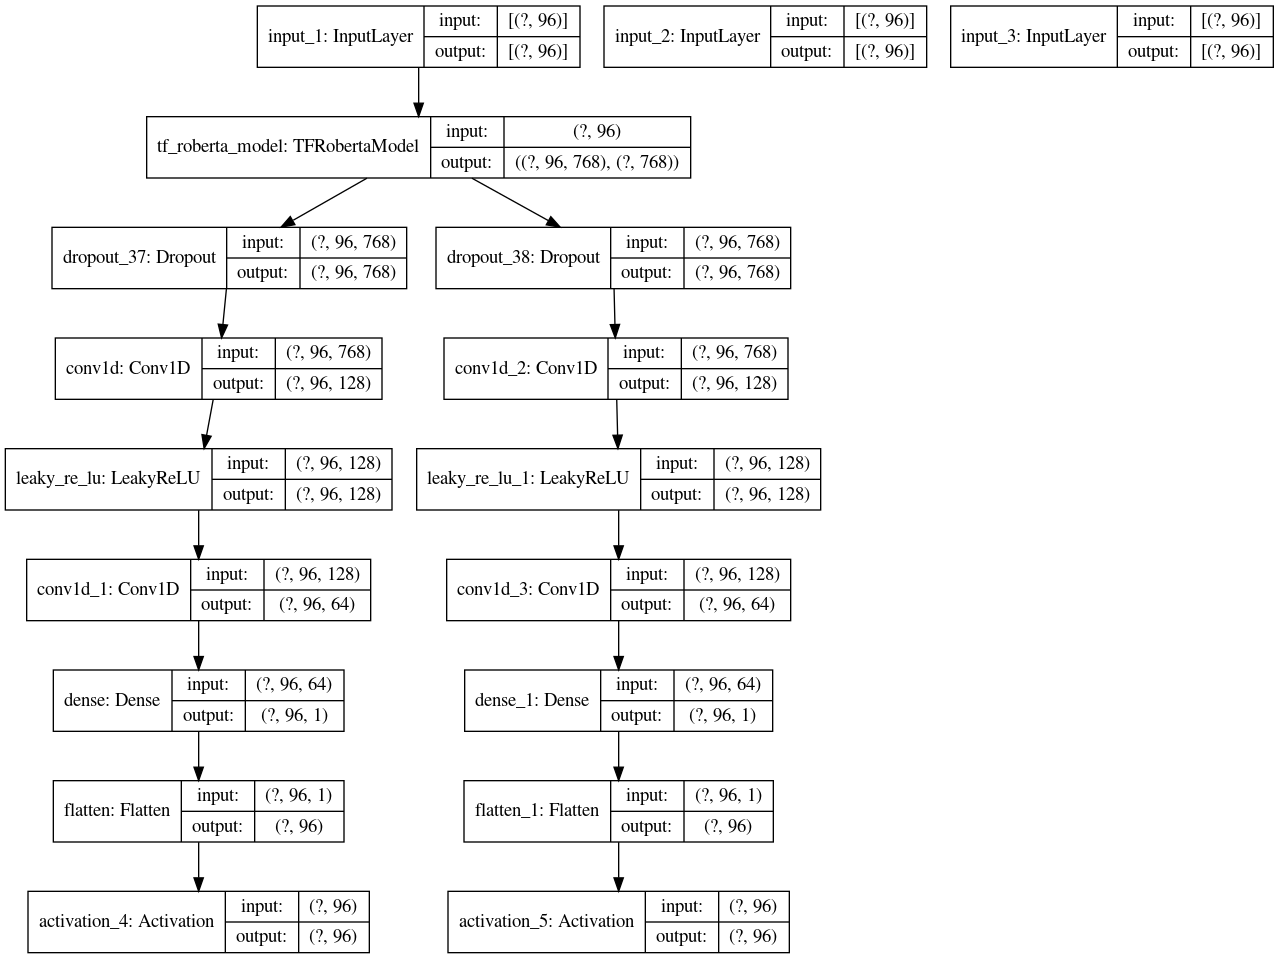

In [33]:
tf.keras.utils.plot_model(model, to_file='roberta_v4.png', show_shapes=True)

In [34]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test_df.loc[k,'text']
    else:
        text1 = " "+" ".join(test_df.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

NameError: name 'preds_start' is not defined

In [ ]:
test_df['selected_text'] = all
test_df[['textID','selected_text']].to_csv('submission_v4.csv',index=False)

In [ ]:
test_inf = pd.read_csv("./submission_v4.csv")
test_inf.shape

In [ ]:
test_inf.head(10)

In [ ]:
answer_st[:10]

In [ ]:
scores = []
for i in range(test_inf.shape[0]):
    scores.append(jaccard(test_inf["selected_text"][i], answer_st[i]))
print("average jaccard score:", sum(scores) / len(scores))

In [ ]:
display = []
cnt = test_inf.shape[0]
for i in range(cnt):
    display.append([answer_st[i].lower(), test_inf["selected_text"][i], test_df["sentiment"][i], scores[i]])
display = pd.DataFrame(display, columns=["y", "y_hat", "sentiment", "jacc_score"])
display.head(10)

### 자카드스코어 0.1 이하인 결과물

In [ ]:
cnt = test.shape[0]
mismatch = []

for i in range(cnt):
    if scores[i] < 0.1:
        mismatch.append([answer_st[i].lower(), test_inf["selected_text"][i], test_df["sentiment"][i], scores[i]])

mismatch = pd.DataFrame(mismatch, columns=["y", "y_hat", "sentiment", "jacc_score"])

In [ ]:
print(mismatch.shape)
mismatch.head(30)

In [ ]:
끝!